In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [22]:
SEED = 20240210
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)


In [23]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        (0.485, 0.456, 0.406),
        (0.229, 0.224, 0.225)
    )
])


In [24]:
from torch.utils.data import Dataset, Subset

SELECTED_CLASSES = [0, 1, 2, 14, 17, 18, 25, 33, 34, 35]
class_to_idx = {c:i for i, c in enumerate(SELECTED_CLASSES)}

def filter_indices(dataset, selected):
    return [i for i, (_, y) in enumerate(dataset) if y in selected]

class RemapSubset(Dataset):
    def __init__(self, dataset, indices, class_to_idx):
        self.dataset = dataset
        self.indices = indices
        self.class_to_idx = class_to_idx

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        x, y = self.dataset[self.indices[i]]
        return x, self.class_to_idx[y]


In [25]:
train_dataset = datasets.GTSRB(
    root="./data",
    split="train",
    download=True,
    transform=transform
)

test_dataset = datasets.GTSRB(
    root="./data",
    split="test",
    download=True,
    transform=transform
)


In [26]:
train_idx = filter_indices(train_dataset, SELECTED_CLASSES)
test_idx  = filter_indices(test_dataset, SELECTED_CLASSES)

train_subset = RemapSubset(train_dataset, train_idx, class_to_idx)
test_subset  = RemapSubset(test_dataset,  test_idx,  class_to_idx)

print(len(train_subset), len(test_subset))


7860 3750


In [27]:
BATCH_SIZE = 32

train_loader = DataLoader(
    train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

test_loader = DataLoader(
    test_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [29]:
model = models.mobilenet_v2(weights='IMAGENET1K_V1')


In [30]:
for param in model.parameters():
    param.requires_grad = False


In [31]:
model.classifier[1] = nn.Linear(1280, 10)


In [32]:
model = model.to(device)



In [33]:
print(model)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [34]:
criterion = nn.CrossEntropyLoss()

optimizer_v1 = optim.Adam(
    model.classifier.parameters(),  # YALNIZ classifier train olunur
    lr=0.0001
)


In [35]:
def train_model(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    accuracy = 100 * correct / total
    return running_loss / len(loader), accuracy


In [36]:
def evaluate_model(model, loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy


In [42]:
EPOCHS = 30

train_acc_v1 = []
test_acc_v1 = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train_model(
        model, train_loader, optimizer_v1, criterion, device
    )
    test_acc = evaluate_model(model, test_loader, device)

    train_acc_v1.append(train_acc)
    test_acc_v1.append(test_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")


Epoch [1/30] Train Acc: 90.27% | Test Acc: 79.47%
Epoch [2/30] Train Acc: 90.45% | Test Acc: 79.81%
Epoch [3/30] Train Acc: 90.97% | Test Acc: 80.21%
Epoch [4/30] Train Acc: 90.83% | Test Acc: 80.13%
Epoch [5/30] Train Acc: 91.22% | Test Acc: 80.11%
Epoch [6/30] Train Acc: 90.99% | Test Acc: 80.64%
Epoch [7/30] Train Acc: 91.68% | Test Acc: 80.91%
Epoch [8/30] Train Acc: 91.56% | Test Acc: 80.19%
Epoch [9/30] Train Acc: 91.59% | Test Acc: 80.64%
Epoch [10/30] Train Acc: 92.01% | Test Acc: 80.16%
Epoch [11/30] Train Acc: 92.42% | Test Acc: 80.99%
Epoch [12/30] Train Acc: 92.09% | Test Acc: 80.61%
Epoch [13/30] Train Acc: 92.35% | Test Acc: 80.83%
Epoch [14/30] Train Acc: 92.12% | Test Acc: 80.64%
Epoch [15/30] Train Acc: 92.18% | Test Acc: 80.91%
Epoch [16/30] Train Acc: 92.65% | Test Acc: 81.23%
Epoch [17/30] Train Acc: 92.72% | Test Acc: 80.72%
Epoch [18/30] Train Acc: 92.19% | Test Acc: 80.56%
Epoch [19/30] Train Acc: 92.62% | Test Acc: 81.49%
Epoch [20/30] Train Acc: 92.72% | Test A

In [38]:
model_v2 = models.mobilenet_v2(weights='IMAGENET1K_V1')

for param in model_v2.parameters():
    param.requires_grad = False

model_v2.classifier[1] = nn.Linear(1280, 10)
model_v2 = model_v2.to(device)


In [40]:
optimizer_v2 = optim.Adam(
    model_v2.classifier.parameters(),
    lr=0.00001
)


In [41]:
EPOCHS = 15

train_acc_v2 = []
test_acc_v2 = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train_model(
        model_v2, train_loader, optimizer_v2, criterion, device
    )
    test_acc = evaluate_model(model_v2, test_loader, device)

    train_acc_v2.append(train_acc)
    test_acc_v2.append(test_acc)

    print(f"[V2] Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")


[V2] Epoch [1/15] Train Acc: 18.72% | Test Acc: 28.37%
[V2] Epoch [2/15] Train Acc: 27.43% | Test Acc: 33.20%
[V2] Epoch [3/15] Train Acc: 35.37% | Test Acc: 42.27%
[V2] Epoch [4/15] Train Acc: 44.21% | Test Acc: 47.76%
[V2] Epoch [5/15] Train Acc: 51.21% | Test Acc: 52.96%
[V2] Epoch [6/15] Train Acc: 56.96% | Test Acc: 55.63%
[V2] Epoch [7/15] Train Acc: 61.04% | Test Acc: 57.63%
[V2] Epoch [8/15] Train Acc: 64.25% | Test Acc: 59.01%
[V2] Epoch [9/15] Train Acc: 66.22% | Test Acc: 59.87%
[V2] Epoch [10/15] Train Acc: 68.73% | Test Acc: 60.40%
[V2] Epoch [11/15] Train Acc: 70.31% | Test Acc: 61.07%
[V2] Epoch [12/15] Train Acc: 71.37% | Test Acc: 62.16%
[V2] Epoch [13/15] Train Acc: 71.90% | Test Acc: 61.97%
[V2] Epoch [14/15] Train Acc: 73.49% | Test Acc: 63.84%
[V2] Epoch [15/15] Train Acc: 74.73% | Test Acc: 63.65%


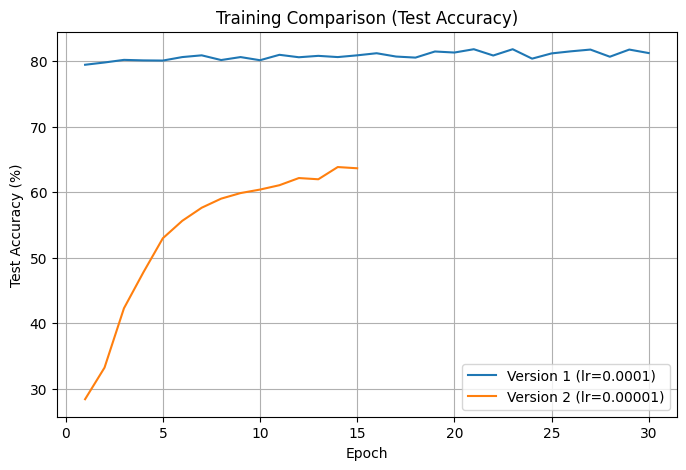

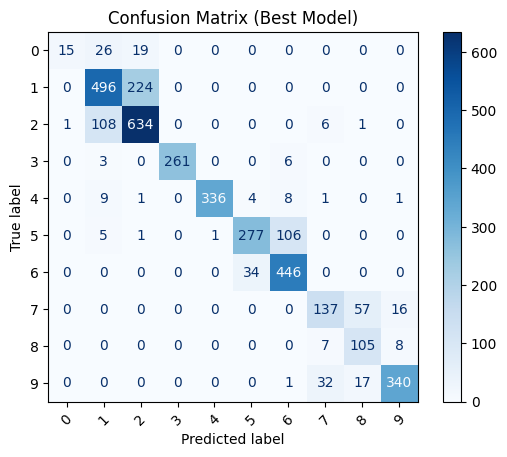

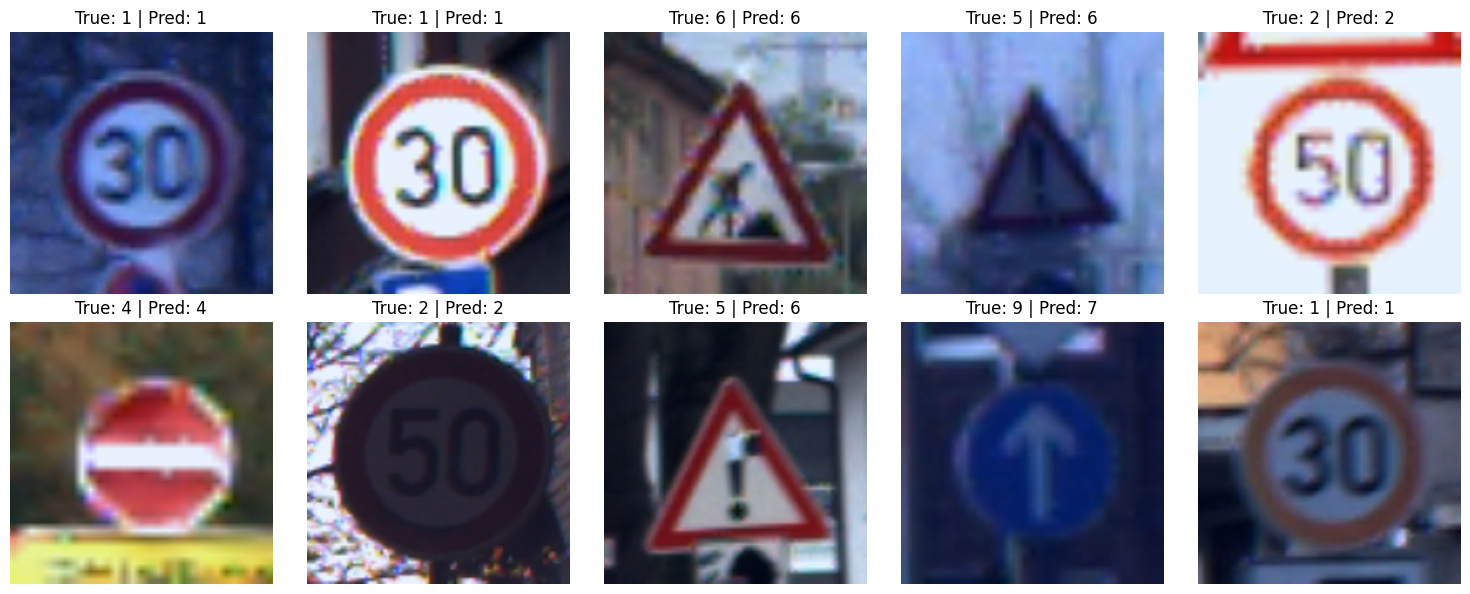

In [43]:
# =========================
# 1) Training comparison qrafiki (V1 vs V2)
# =========================
import matplotlib.pyplot as plt

epochs_v1 = range(1, len(test_acc_v1) + 1)
epochs_v2 = range(1, len(test_acc_v2) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs_v1, test_acc_v1, label="Version 1 (lr=0.0001)")
plt.plot(epochs_v2, test_acc_v2, label="Version 2 (lr=0.00001)")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.title("Training Comparison (Test Accuracy)")
plt.legend()
plt.grid(True)
plt.show()


# =========================
# 2) Confusion Matrix (ən yaxşı model üçün)
# =========================
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)   # best model (V1)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix (Best Model)")
plt.show()


# =========================
# 3) 10 Prediction şəkli (true / predicted)
# =========================
import random

model.eval()
fig, axes = plt.subplots(2, 5, figsize=(15,6))
axes = axes.flatten()

indices = random.sample(range(len(test_subset)), 10)

with torch.no_grad():
    for ax, idx in zip(axes, indices):
        image, label = test_subset[idx]
        img = image.unsqueeze(0).to(device)
        output = model(img)
        _, pred = torch.max(output, 1)

        # denormalize for display
        img_show = image.permute(1,2,0).cpu().numpy()
        img_show = (img_show - img_show.min()) / (img_show.max() - img_show.min())

        ax.imshow(img_show)
        ax.set_title(f"True: {label} | Pred: {pred.item()}")
        ax.axis("off")

plt.tight_layout()
plt.show()
